# Name frequency notebook

This notebook shows how to create a simple plot and then do some basic analysis.  

## Get the data

You need to first download the US baby names database, which is available from kaggle.com.

In [1]:
#!curl https://www.kaggle.com/kaggle/us-baby-names/downloads/database.sqlite.zip -o database.sqlite.zip # Mac
#!wget https://www.kaggle.com/kaggle/us-baby-names/downloads/database.sqlite.zip # Linux/Windows

First, let's set up the environment.  

In [2]:
import os
import sys
import sqlite3
import argparse
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline  


/Users/hwwulsin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Now make some formatting changes.  

In [3]:
# Plot style
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

/Users/hwwulsin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


Read the database.  

In [4]:
# Read into dataframe from database
if not os.path.isfile('database.sqlite'):
    print " database.sqlite not in current directory. exiting..."
    sys.exit(0)

con = sqlite3.connect("database.sqlite")
df = pd.read_sql("SELECT * from NationalNames",con)

Check the contents.  

In [5]:
df.head()

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


Check the date range.  

In [6]:
df['Year'].head()

0    1880
1    1880
2    1880
3    1880
4    1880
Name: Year, dtype: int64

In [7]:
df['Year'].tail()

1825428    2014
1825429    2014
1825430    2014
1825431    2014
1825432    2014
Name: Year, dtype: int64

So the data covers years 1880 to 2014.  

## First version of a simple plot

Let's make a time history plot of the number of US babies born with the name Richard (as in Feynman, who received the 1965 Nobel Prize in Physics). 

First, restrict ourselves to the information in the database about the name Richard.  

In [8]:
df_name = df[ df['Name'] == 'Richard' ]

In [9]:
df_name.head()

,Id,Name,Year,Gender,Count
964,965,Richard,1880,M,728
2959,2960,Richard,1881,M,641
4984,4985,Richard,1882,M,746
7136,7137,Richard,1883,M,649
9340,9341,Richard,1884,M,749


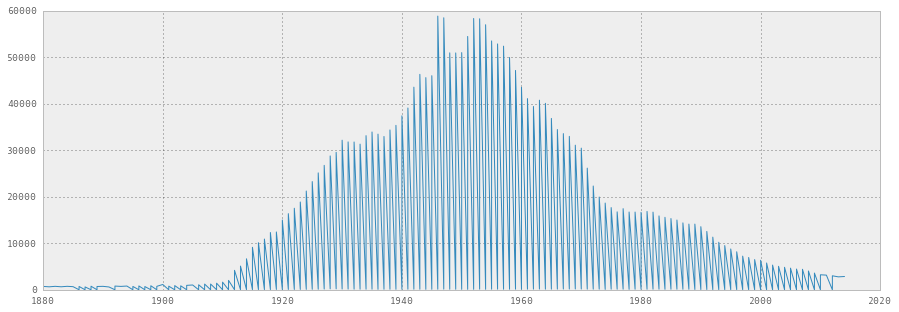

In [10]:
plt.plot(df_name['Year'],df_name['Count'])

That looks really awful.  Let's see what happened.  

In [11]:
df_name.tail(15)

,Id,Name,Year,Gender,Count
1532198,1532199,Richard,2006,F,8
1539004,1539005,Richard,2006,M,4466
1566575,1566576,Richard,2007,F,8
1573579,1573580,Richard,2007,M,4416
1607662,1607663,Richard,2008,F,5
1608409,1608410,Richard,2008,M,4052
1637778,1637779,Richard,2009,F,7
1643186,1643187,Richard,2009,M,3604
1676789,1676790,Richard,2010,F,5
1677518,1677519,Richard,2010,M,3228


There are small numbers of female names "Richard" in many years (some could be typographical errors).  This accounts for the sawtooth shape.  Let's look only at the number of male babies named Richard.  

In [12]:
df_name = df_name[ df_name['Gender'] == "M"]

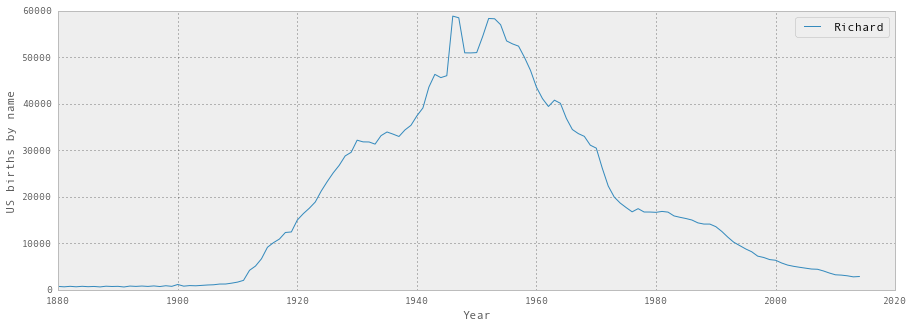

In [13]:
line, = plt.plot(df_name['Year'],df_name['Count'])
plt.legend([line], ['Richard'])
plt.xlabel('Year')
plt.ylabel('US births by name')

## Plot multiple names simulataneously
We probably want to make many plots similar to the one above.  Let's write a function to do it.  

In [14]:
def makeNamePlot( names, gender, normalize=False ):

    df_name = df[ df['Name'].isin(names) ]
    if gender=="B":
        df_name = df_name.groupby('Year', as_index=False).sum()
    else:
        df_name = df_name[ df_name['Gender']==gender ].groupby(['Year','Name'], as_index=False).sum()
        
    if normalize:
        print " normalizing the counts to peak value of 1"
        for name in names:
            maxVal = max(df_name[ df_name['Name']==name ]['Count'])
            nameReq = df_name['Name']==name
            df_name.loc[ nameReq, 'Count'] = df_name.loc[ nameReq, 'Count'] / maxVal

    if len(names) > 1:
        fig, ax = plt.subplots()
        labels = []
        for key, grp in df_name.groupby(['Name']):
            ax = grp.plot(ax=ax, kind='line', x='Year', y='Count')
            labels.append(key)
        lines, _ = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')

    else :
        line, = plt.plot(df_name['Year'],df_name['Count'])            
        plt.legend([line], [names[0]]) 

    plt.xlabel('Year')
    plt.ylabel('US births by name')
    

Using this function, we can plot the names of the five most recent Physics Nobel Laureates born in the US:  David Wineland (2012), Adam Riess (2011), Brian Schmidt (2011), Saul Perlmutter (2011), and George Smith (2009).  

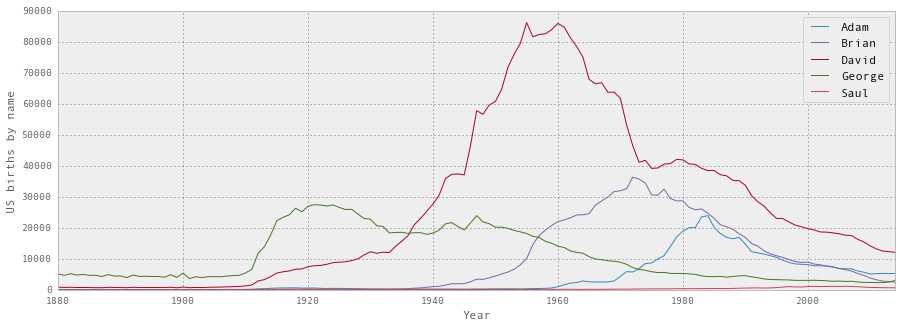

In [15]:
makeNamePlot(['David', 'Adam', 'Brian', 'Saul', 'George'], 'M')

## Trend Analysis 
Let's answer a simple question:  was a given name increasing or decreasing in popularity around a given year?  

There are many metrics we could devise to answer this question.  I'll use a very simple one:  the difference in averge frequency of the name in the five years before and the 5 years after the year in question.  First let's write a function to calculate this.  

In [16]:
def isSlopePositive( name, year, gender ):
    # Consider years 5 before and 5 after the year in question 
    # Return true if the average of the 5 years after is greater than
    # the average of the 5 years before.  
    df_name = df[ (df['Name'] == name) & (df['Gender'] == gender)]
    df_name = df_name[(df_name['Year']>=year-5) & (df_name['Year']<=year+5)]
    avgBefore = df_name[:5].Count.mean()
    avgAfter  = df_name[6:].Count.mean()
    slopePositive = False
    if avgAfter > avgBefore:         
        slopePositive = True
    print "In the year", year, "the name", name, "for", gender, "births was trending", "upward." if slopePositive else "downward."


Let's use this function to find the trend for names in the years that each of these five physicists were born.  

In [17]:
isSlopePositive("David", 1944, "M")
isSlopePositive("Adam", 1969, "M")
isSlopePositive("Brian", 1967, "M")
isSlopePositive("Saul", 1959, "M")
isSlopePositive("George", 1930, "M")

In the year 1944 the name David for M births was trending upward.
In the year 1969 the name Adam for M births was trending upward.
In the year 1967 the name Brian for M births was trending upward.
In the year 1959 the name Saul for M births was trending upward.
In the year 1930 the name George for M births was trending downward.


So all the names except George were gaining in popularity.  

## Test Freakanomics 

In their bestselling book Freakonomics, Stephen Dubner and Steven Levitt claim that parents are more conservative in naming sons than daughters, that is that they are more likely to choose a common boys name for a son than they are to choose a common girls name for a dauther.  They argue that parents hold higher expectations of professional success for their sons, and thus want to give them "safe" (i.e., common) names that are unlikely to jeopardize that success.  Their expectations for girls' success are lower so they are more willing to assign them "risky" (i.e. less common) names. (At least this is what I remember from reading the book about a decade ago.)  

If their claim is correct, there should be a wider variety of girls names than boys names.  Let's test this.  


First, we need to define a metric for the diversity of names for a given gender.  There are many ways we could do this, but let's choose a very simple definition:  the total number of unique names assigned to at least 5 births in a given year.  The names in our dataset are all required to have at least 5 births in a given year (more rare names are omitted for reasons of privacy).  

Let's first check it for a single year. 

In [18]:
len(df[(df['Year']==2012) & (df['Gender'] == 'M')])

14216

In [19]:
len(df[(df['Year']==2012) & (df['Gender'] == 'F')])

19468

In 2012, there were 37% more girls names assigned than boys names.  So in that year the Freakonomics claim holds true.  Let's make a plot to track this over time.  

In [33]:
df[df['Gender'] == 'M'].groupby('Year').count()['Count'].head()

Year
1880    1058
1881     997
1882    1099
1883    1030
1884    1125
Name: Count, dtype: int64

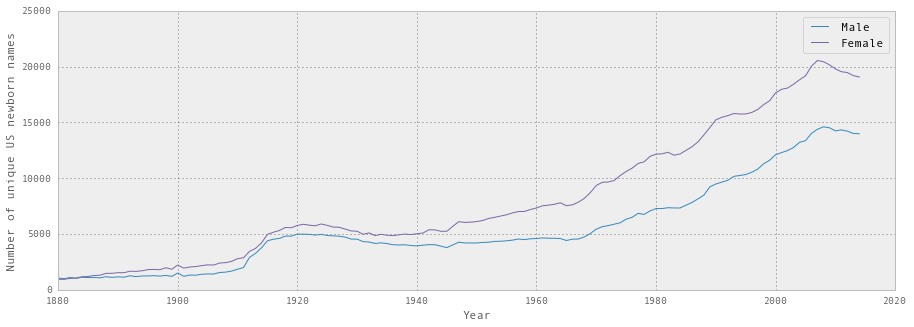

In [25]:
lineM, = plt.plot(df[df['Gender'] == 'M'].groupby('Year').count()['Count'])
lineF, = plt.plot(df[df['Gender'] == 'F'].groupby('Year').count()['Count'])
plt.legend([lineM, lineF], ["Male", "Female"]) 
plt.xlabel('Year')
plt.ylabel('Number of unique US newborn names')

Let's also make a plot of the fraction of the total unique names assigned assigned to males and females.

In [26]:
df_countM   = df[df['Gender'] == 'M'].groupby('Year').count()['Count']
df_countF   = df[df['Gender'] == 'F'].groupby('Year').count()['Count']
df_countTot =                      df.groupby('Year').count()['Count']
df_countTot.head()


Year
1880    2000
1881    1935
1882    2127
1883    2084
1884    2297
Name: Count, dtype: int64

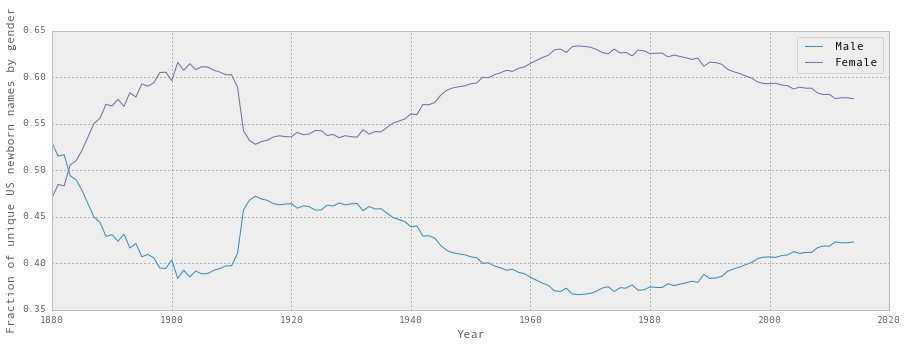

In [31]:
lineM, = plt.plot(df_countM / df_countTot)
lineF, = plt.plot(df_countF / df_countTot)
plt.legend([lineM, lineF], ["Male", "Female"]) 
plt.xlabel('Year')
plt.ylabel('Fraction of unique US newborn names by gender')

Since 1885, the fraction of unique names assigned to newborn girls has been larger every year, consistent with the claim that parents are more likely to choose a common name for a son than for a daughter.  Freakonomics passes the test.  